In [194]:
#Import Libraries
import pandas as pd
import numpy as np
import random 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential

In [5]:
from google.colab import files
uploaded = files.upload()

Saving cs-training.csv to cs-training.csv


In [7]:
#load the train dataset
df_train = pd.read_csv('cs-training.csv')

df_train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [8]:
#remove the index column
df_train = df_train.drop(['Unnamed: 0'], axis=1)

df_train

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [10]:
#Repeat the same steps with test data
from google.colab import files
uploaded = files.upload()

Saving cs-test.csv to cs-test (1).csv


In [11]:
df_test = pd.read_csv('cs-test.csv')

df_test = df_test.drop(['Unnamed: 0'], axis=1)
df_test

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
101498,NaN,0.282653,24,0,0.068522,1400.0,5,0,0,0,0.0
101499,NaN,0.922156,36,3,0.934217,7615.0,8,0,2,0,4.0
101500,NaN,0.081596,70,0,836.000000,NaN,3,0,0,0,NaN
101501,NaN,0.335457,56,0,3568.000000,NaN,8,0,2,1,3.0


## EDA
Label distribution:

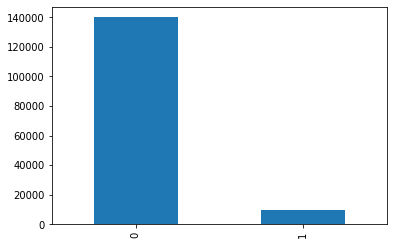

In [12]:
df_train['SeriousDlqin2yrs'].value_counts().plot(kind='bar')

In [13]:
print("Proportion of People Who Defaulted: {}".format(df_train["SeriousDlqin2yrs"].sum() / len(df_train)))

Proportion of People Who Defaulted: 0.06684


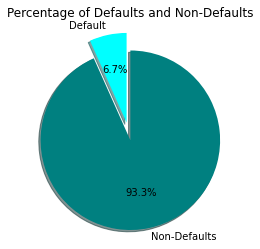

In [14]:
## Pie Chart
labels = 'Default', 'Non-Defaults'
sizes = [6.684, 93.316]
explode = (0.2, 0)
cols    = ['#00FFFF', '#008080']

fig = plt.figure(figsize = (4,4))
plt.pie(sizes, explode=explode, colors = cols, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')
plt. title("Percentage of Defaults and Non-Defaults")
plt.show()

Text(0.5, 1.0, 'SeriousDlqin2yrs = 1')

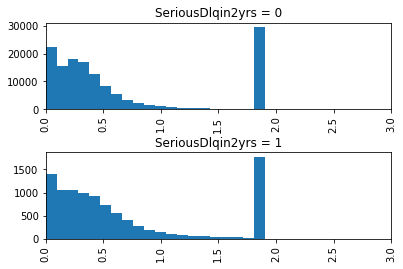

In [200]:
#take a look at DebtRatio distribution in the train data set
DebtRatio_hist = df_train['DebtRatio'].hist(by=df_train['SeriousDlqin2yrs'], bins=20, layout=(2,1))
DebtRatio_hist[0].set_xlim((0,3))
DebtRatio_hist[0].set_title('SeriousDlqin2yrs = 0')
DebtRatio_hist[1].set_xlim((0,3))
DebtRatio_hist[1].set_title('SeriousDlqin2yrs = 1')

Text(0.5, 1.0, 'SeriousDlqin2yrs = 1')

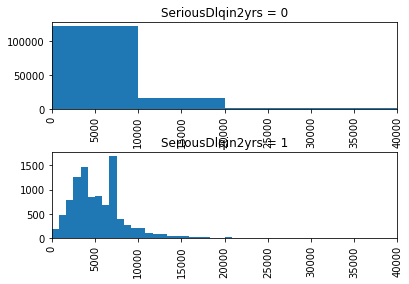

In [207]:
#take a look at Monthly income distribution in the train data set
MonthlyIncome_hist = df_train['MonthlyIncome'].hist(by=df_train['SeriousDlqin2yrs'], bins=300, layout=(2,1))
MonthlyIncome_hist[0].set_xlim((0,40000))
MonthlyIncome_hist[0].set_title('SeriousDlqin2yrs = 0')
MonthlyIncome_hist[1].set_xlim((0,40000))
MonthlyIncome_hist[1].set_title('SeriousDlqin2yrs = 1')

In [ ]:
age_hist = df_train['age'].hist(by=df_train['SeriousDlqin2yrs'], bins=20, layout=(2,1))
age_hist[0].set_xlim((0,100))
age_hist[0].set_title('SeriousDlqin2yrs = 0')
age_hist[1].set_xlim((0,100))
age_hist[1].set_title('SeriousDlqin2yrs = 1')

Comparing the above two graph, generally, younger people (between 20 and 40) were more responsible for defaulting.

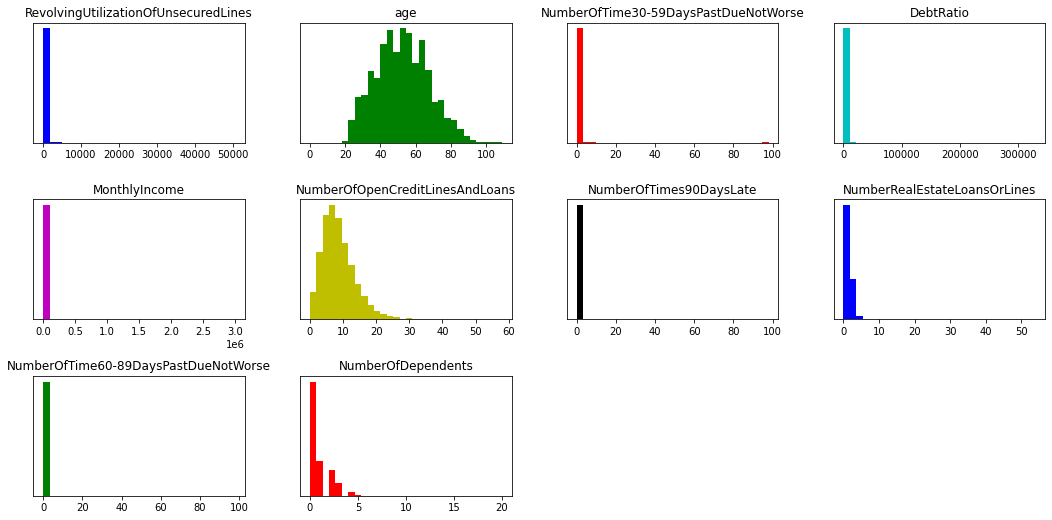

In [16]:
cols = list(df_train.columns)
cols = cols[1:]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c']

fig = plt.figure(figsize=(15, 12))
for i in range(0, len(cols)):
    plt.subplot(5, 4, i+1)
    f = plt.gca()
    f.axes.get_yaxis().set_visible(False)

    plt.hist(df_train[cols[i]], bins=30, color=colors[i])
    plt.title(cols[i])

plt.tight_layout()

### Fill Missing Data
- Fill missing MonthlyIncome with the mean by each age group
- Fill missing NumberofDependents with the mode

In [17]:
#Slicing train and test data to combine the two together in order to fill missing data for both at the same time
X_train = df_train.iloc[:,1:]
y_train = df_train.iloc[:,0]
X_test = df_test.iloc[:,1:]
X_train.shape, y_train.shape, X_test.shape

((150000, 10), (150000,), (101503, 10))

In [18]:
#This is train and test combined without y
X_all = pd.concat([X_train, X_test],axis=0).reset_index(drop=True)
X_all

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...
251498,0.282653,24,0,0.068522,1400.0,5,0,0,0,0.0
251499,0.922156,36,3,0.934217,7615.0,8,0,2,0,4.0
251500,0.081596,70,0,836.000000,NaN,3,0,0,0,NaN
251501,0.335457,56,0,3568.000000,NaN,8,0,2,1,3.0


In [19]:
#Bin Age by 3 categories
def Age_binned(age):
    if (age < 35):
        return 'junior'
    elif (age >= 35) & (age < 60):
        return'senior'
    else:
        return 'mature'

X_all['Agebinned'] = X_all['age'].apply(Age_binned)

X_all['MonthlyIncome'] = pd.to_numeric(X_all['MonthlyIncome'], downcast="float")

income_dict = X_all.groupby('Agebinned')['MonthlyIncome'].mean().to_dict()
income_dict

{'junior': 4023.322509765625,
 'mature': 7041.40478515625,
 'senior': 7239.1865234375}

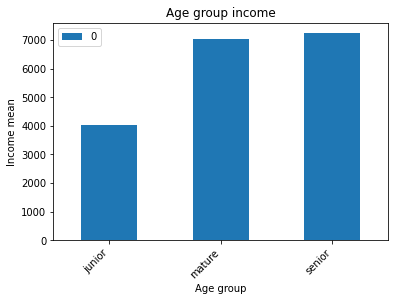

In [242]:
pd.Series(income_dict).to_frame().plot(kind='bar', title = 'Age group income')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Age group', fontsize=10)
plt.ylabel('Income mean', fontsize=10);

In [20]:
#fill missing MonthlyIncome data with mean of each age group
for k, v in income_dict.items():
    X_all['MonthlyIncome'] = np.where((X_all['MonthlyIncome'].isnull()) & \
                                         (X_all['Agebinned'] == k), int(v), X_all['MonthlyIncome'])

In [21]:
X_all.isnull().sum()

RevolvingUtilizationOfUnsecuredLines       0
age                                        0
NumberOfTime30-59DaysPastDueNotWorse       0
DebtRatio                                  0
MonthlyIncome                              0
NumberOfOpenCreditLinesAndLoans            0
NumberOfTimes90DaysLate                    0
NumberRealEstateLoansOrLines               0
NumberOfTime60-89DaysPastDueNotWorse       0
NumberOfDependents                      6550
Agebinned                                  0
dtype: int64

In [22]:
X_all['NumberOfDependents'].mode()

0    0.0
dtype: float64

In [23]:
X_all.groupby('Agebinned')['NumberOfDependents'].value_counts()

Agebinned  NumberOfDependents
junior     0.0                   21836
           1.0                    4609
           2.0                    3009
           3.0                    1202
           4.0                     369
           5.0                      56
           6.0                       9
           7.0                       3
mature     0.0                   60817
           1.0                   12935
           2.0                    2798
           3.0                     882
           4.0                     204
           5.0                      51
           6.0                      13
           7.0                       6
           8.0                       4
           10.0                      1
senior     0.0                   62867
           2.0                   27013
           1.0                   26390
           3.0                   14022
           4.0                    4284
           5.0                    1165
           6.0                    

In [24]:
#fill missing NumberOfDependents with mode
X_all['NumberOfDependents'] = X_all['NumberOfDependents'].fillna('0')

X_all.isnull().sum()

RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
Agebinned                               0
dtype: int64

In [25]:
X_train[['MonthlyIncome','NumberOfDependents']] = \
    X_all.loc[:X_train.shape[0],['MonthlyIncome','NumberOfDependents']]
df_train[['MonthlyIncome','NumberOfDependents']] =  X_train[['MonthlyIncome','NumberOfDependents']]

X_test[['MonthlyIncome','NumberOfDependents']] = \
    X_all.loc[-X_test.shape[0]:,['MonthlyIncome','NumberOfDependents']]
df_test[['MonthlyIncome','NumberOfDependents']] =  X_test[['MonthlyIncome','NumberOfDependents']]

### Feature Engineering
#### Handling Outliers starting from the RevolvingUtilizationOfUnsecuredLines column

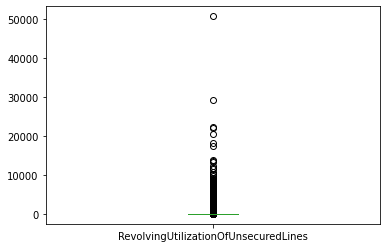

In [26]:
# taking a look at the ratio distribution
df_train['RevolvingUtilizationOfUns4ecuredLines'].plot(kind='box')

In [27]:
df_train.RevolvingUtilizationOfUnsecuredLines.quantile([.75])

0.75    0.559046
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [28]:
df_train.RevolvingUtilizationOfUnsecuredLines.quantile([.99])

0.99    1.092956
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [29]:
#Looks like 99% of the people have a ratio less than 1.09. Now compare the people's debt ratio with their default
df_train[(df_train['RevolvingUtilizationOfUnsecuredLines'] > .9) & \
         (df_train['RevolvingUtilizationOfUnsecuredLines'] <= 3)].SeriousDlqin2yrs.describe()

count    19777.000000
mean         0.225363
std          0.417832
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: SeriousDlqin2yrs, dtype: float64

In [30]:
#compare people with debt ratio greater than 3 and their default
df_train[(df_train['RevolvingUtilizationOfUnsecuredLines'] > 3)].SeriousDlqin2yrs.describe()

count    292.000000
mean       0.099315
std        0.299598
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: SeriousDlqin2yrs, dtype: float64

In [31]:
#looks like these people are not defaulting more even though they own more (3 times of their credit card limit); 
#These can be considered as outliers and thus removing them
df_train = df_train.drop(df_train[df_train['RevolvingUtilizationOfUnsecuredLines'] > 3].index)

In [32]:
df_train[(df_train['RevolvingUtilizationOfUnsecuredLines'] > 3)].SeriousDlqin2yrs.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: SeriousDlqin2yrs, dtype: float64

#### Removing Ourliers in the age column

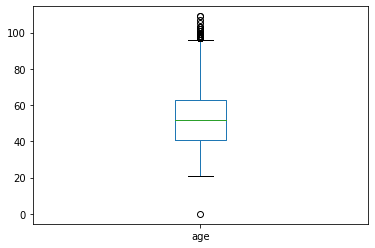

In [33]:
df_train['age'].plot(kind='box')

In [34]:
#Take a look at the majority of age and their default
df_train[(df_train['age'] >= 40) & \
         (df_train['age'] <= 60)].SeriousDlqin2yrs.describe()

count    72801.000000
mean         0.072678
std          0.259608
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: SeriousDlqin2yrs, dtype: float64

In [35]:
df_train[(df_train['age'] > 100)].SeriousDlqin2yrs.describe()

count    13.000000
mean      0.076923
std       0.277350
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: SeriousDlqin2yrs, dtype: float64

In [36]:
df_train[(df_train['age'] < 18)].SeriousDlqin2yrs.describe()

count    1.0
mean     0.0
std      NaN
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: SeriousDlqin2yrs, dtype: float64

In [37]:
#decided to remove age outlier (age less than 18 years old)
df_train = df_train.drop(df_train[df_train['age'] < 18].index)

#### Handling Outliers in the past due columns

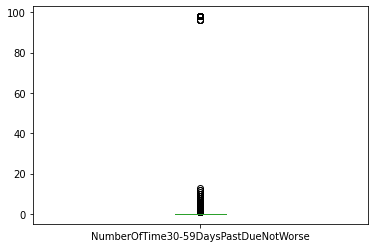

In [38]:
df_train['NumberOfTime30-59DaysPastDueNotWorse'].plot(kind='box')

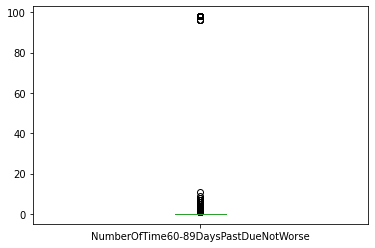

In [39]:
df_train['NumberOfTime60-89DaysPastDueNotWorse'].plot(kind='box')

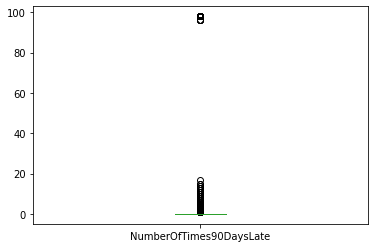

In [40]:
df_train['NumberOfTimes90DaysLate'].plot(kind='box')

In [41]:
df_train['NumberOfTime30-59DaysPastDueNotWorse'].value_counts()

0     125765
1      16014
2       4584
3       1748
4        746
5        342
98       264
6        140
7         54
8         25
9         12
96         5
10         4
12         2
13         1
11         1
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64

It looks like people with 96 times past due and 98 times past due should be considered as outliers，
Since it is strange that no one is between 17 and 95 times late, but hundreds of people are 98 times late.

In [42]:
#take a look at these people's default
df_train[df_train['NumberOfTime30-59DaysPastDueNotWorse'] > 95][['SeriousDlqin2yrs',\
                                                    'NumberOfTime60-89DaysPastDueNotWorse',\
                                                    'NumberOfTime30-59DaysPastDueNotWorse',\
                                                    'NumberOfTimes90DaysLate']].describe()

,SeriousDlqin2yrs,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate
count,269.000000,269.000000,269.000000,269.000000
mean,0.546468,97.962825,97.962825,97.962825
std,0.498764,0.270628,0.270628,0.270628
min,0.000000,96.000000,96.000000,96.000000
25%,0.000000,98.000000,98.000000,98.000000
50%,1.000000,98.000000,98.000000,98.000000
75%,1.000000,98.000000,98.000000,98.000000
max,1.000000,98.000000,98.000000,98.000000


In [43]:
#looks like all these people above are 98 or 96 times late, which is possible
#Decided to handle these outliers by replacing the late times to 18 times instead of 98 or 96
df_train.loc[df_train['NumberOfTime30-59DaysPastDueNotWorse'] > 95, 'NumberOfTime30-59DaysPastDueNotWorse'] = 18
df_train.loc[df_train['NumberOfTime60-89DaysPastDueNotWorse'] > 95, 'NumberOfTime60-89DaysPastDueNotWorse'] = 18
df_train.loc[df_train['NumberOfTimes90DaysLate'] > 95, 'NumberOfTimes90DaysLate'] = 18

#### Handling Outliers in DebtRatio, NumberRealEstateLoansOrLines, and NumberOfOpenCreditLinesAndLoans

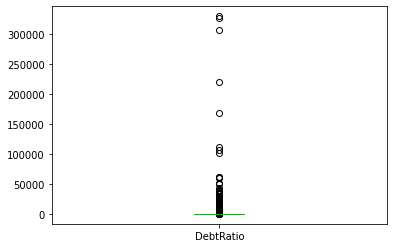

In [44]:
df_train['DebtRatio'].plot(kind='box')

In [45]:
q1, q3 = df_train['DebtRatio'].quantile([0.25, .75])

iqr = q3 - q1

top_boundary = q3 + (iqr * 1.5)

df_train['DebtRatio_capped'] = df_train['DebtRatio']

df_train.loc[df_train['DebtRatio_capped'] >= top_boundary, 'DebtRatio_capped'] = top_boundary

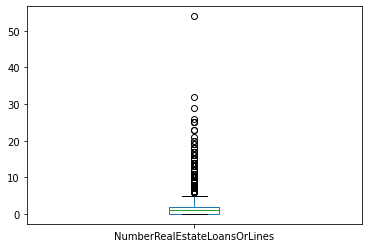

In [46]:
df_train['NumberRealEstateLoansOrLines'].plot(kind='box')

In [47]:
q1, q3 = df_train['NumberRealEstateLoansOrLines'].quantile([0.25, .75])

iqr = q3 - q1

top_boundary = q3 + (iqr * 1.5)

df_train['NumberRealEstateLoansOrLines_capped'] = df_train['NumberRealEstateLoansOrLines']

df_train.loc[df_train['NumberRealEstateLoansOrLines_capped'] >= top_boundary, 'NumberRealEstateLoansOrLines_capped'] = top_boundary

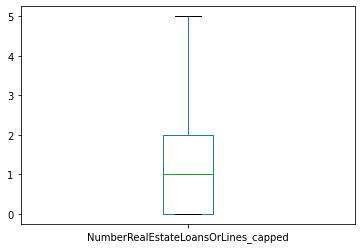

In [48]:
df_train['NumberRealEstateLoansOrLines_capped'].plot(kind='box')

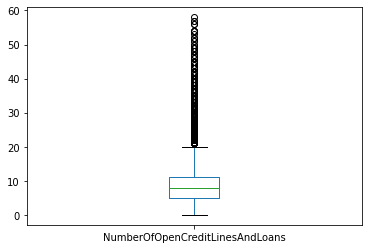

In [49]:
df_train['NumberOfOpenCreditLinesAndLoans'].plot(kind='box')

In [50]:
q1, q3 = df_train['NumberOfOpenCreditLinesAndLoans'].quantile([0.25, .75])

iqr = q3 - q1

top_boundary = q3 + (iqr * 1.5)

df_train['NumberOfOpenCreditLinesAndLoans_capped'] = df_train['NumberOfOpenCreditLinesAndLoans']

df_train.loc[df_train['NumberOfOpenCreditLinesAndLoans_capped'] >= top_boundary, 'NumberOfOpenCreditLinesAndLoans_capped'] = top_boundary

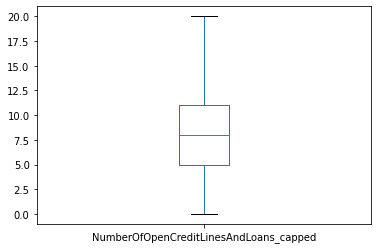

In [51]:
df_train['NumberOfOpenCreditLinesAndLoans_capped'].plot(kind='box')

In [52]:
#drop previous columns
cols_drop = ["DebtRatio","NumberRealEstateLoansOrLines","NumberOfOpenCreditLinesAndLoans"]
df_train.drop(cols_drop, axis=1, inplace=True)

In [53]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149707 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   SeriousDlqin2yrs                        149707 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines    149707 non-null  float64
 2   age                                     149707 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse    149707 non-null  int64  
 4   MonthlyIncome                           149707 non-null  float32
 5   NumberOfTimes90DaysLate                 149707 non-null  int64  
 6   NumberOfTime60-89DaysPastDueNotWorse    149707 non-null  int64  
 7   NumberOfDependents                      149707 non-null  object 
 8   DebtRatio_capped                        149707 non-null  float64
 9   NumberRealEstateLoansOrLines_capped     149707 non-null  int64  
 10  NumberOfOpenCreditLinesAndLoans_capped  1497

In [54]:
df_train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,MonthlyIncome,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,DebtRatio_capped,NumberRealEstateLoansOrLines_capped,NumberOfOpenCreditLinesAndLoans_capped
count,149707.000000,149707.000000,149707.000000,149707.000000,1.497070e+05,149707.000000,149707.000000,149707.000000,149707.000000,149707.000000
mean,0.066777,0.321380,52.300995,0.277716,6.703135e+03,0.122586,0.096936,0.662284,1.002231,8.332443
std,0.249636,0.358348,14.771220,1.025420,1.289559e+04,0.900209,0.827811,0.686651,1.020338,4.737878
min,0.000000,0.000000,21.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029752,41.000000,0.000000,3.900000e+03,0.000000,0.000000,0.174960,0.000000,5.000000
50%,0.000000,0.153444,52.000000,0.000000,6.306000e+03,0.000000,0.000000,0.366481,1.000000,8.000000
75%,0.000000,0.555395,63.000000,0.000000,7.395000e+03,0.000000,0.000000,0.866824,2.000000,11.000000
max,1.000000,2.984534,109.000000,18.000000,3.008750e+06,18.000000,18.000000,1.904619,5.000000,20.000000


In [55]:
#rename columns
df_train = df_train.rename(columns={'DebtRatio_capped': 'DebtRatio', \
                         'NumberRealEstateLoansOrLines_capped': 'NumberRealEstateLoansOrLines', \
                        'NumberOfOpenCreditLinesAndLoans_capped': 'NumberOfOpenCreditLinesAndLoans'})

In [56]:
df_train

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,MonthlyIncome,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,DebtRatio,NumberRealEstateLoansOrLines,NumberOfOpenCreditLinesAndLoans
0,1,0.766127,45,2,9120.0,0,0,2,0.802982,5,13
1,0,0.957151,40,0,2600.0,0,0,1,0.121876,0,4
2,0,0.658180,38,1,3042.0,1,0,0,0.085113,0,2
3,0,0.233810,30,0,3300.0,0,0,0,0.036050,0,5
4,0,0.907239,49,1,63588.0,0,0,0,0.024926,1,7
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,2100.0,0,0,0,0.225131,1,4
149996,0,0.299745,44,0,5584.0,0,0,2,0.716562,1,4
149997,0,0.246044,58,0,7239.0,0,0,0,1.904619,1,18
149998,0,0.000000,30,0,5716.0,0,0,0,0.000000,0,4


### Feature selection

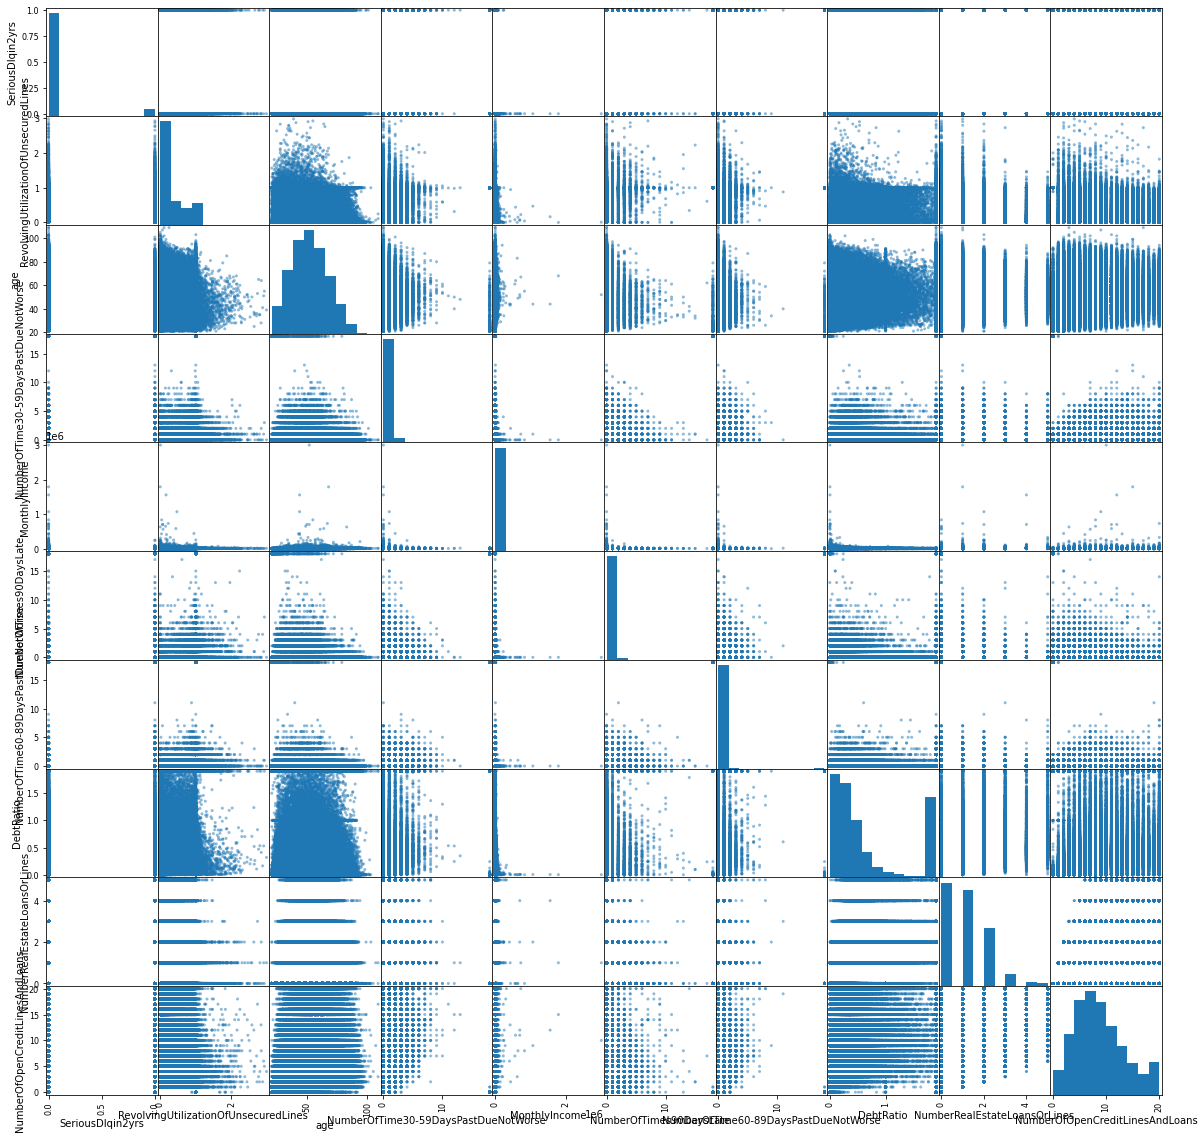

In [57]:
pd.plotting.scatter_matrix(df_train, figsize=(20, 20));

In [58]:
df_train.corr().style.background_gradient(cmap='coolwarm', axis=None)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,MonthlyIncome,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,DebtRatio,NumberRealEstateLoansOrLines,NumberOfOpenCreditLinesAndLoans
SeriousDlqin2yrs,1.000000,0.285640,-0.115360,0.245098,-0.019363,0.236798,0.180558,0.003907,-0.015953,-0.033369
RevolvingUtilizationOfUnsecuredLines,0.285640,1.000000,-0.277894,0.225062,-0.035249,0.204433,0.155642,-0.019552,-0.079140,-0.169015
age,-0.115360,-0.277894,1.000000,-0.086847,0.041042,-0.088069,-0.075291,0.084284,0.035577,0.150776
NumberOfTime30-59DaysPastDueNotWorse,0.245098,0.225062,-0.086847,1.000000,-0.008692,0.697674,0.755437,-0.019403,-0.004212,0.001382
MonthlyIncome,-0.019363,-0.035249,0.041042,-0.008692,1.000000,-0.018571,-0.013657,-0.041550,0.114930,0.084823
NumberOfTimes90DaysLate,0.236798,0.204433,-0.088069,0.697674,-0.018571,1.000000,0.836356,-0.027099,-0.072570,-0.116067
NumberOfTime60-89DaysPastDueNotWorse,0.180558,0.155642,-0.075291,0.755437,-0.013657,0.836356,1.000000,-0.024902,-0.048117,-0.077503
DebtRatio,0.003907,-0.019552,0.084284,-0.019403,-0.041550,-0.027099,-0.024902,1.000000,0.139765,0.038087
NumberRealEstateLoansOrLines,-0.015953,-0.079140,0.035577,-0.004212,0.114930,-0.072570,-0.048117,0.139765,1.000000,0.452292
NumberOfOpenCreditLinesAndLoans,-0.033369,-0.169015,0.150776,0.001382,0.084823,-0.116067,-0.077503,0.038087,0.452292,1.000000


Stronger correlations: 
- Age vs. RevolvingUtilizationOfUnsecuredLines;
- number of days past due vs. SeriousDlqin2yrs

In [59]:
#decide to remove the following columns from features
cols_drop = ['RevolvingUtilizationOfUnsecuredLines',\
             'NumberOfTime60-89DaysPastDueNotWorse',\
             'NumberOfTime30-59DaysPastDueNotWorse']
df_train.drop(cols_drop, axis=1, inplace=True)

In [60]:
df_train.corr().style.background_gradient(cmap='coolwarm', axis=None)

,SeriousDlqin2yrs,age,MonthlyIncome,NumberOfTimes90DaysLate,DebtRatio,NumberRealEstateLoansOrLines,NumberOfOpenCreditLinesAndLoans
SeriousDlqin2yrs,1.000000,-0.115360,-0.019363,0.236798,0.003907,-0.015953,-0.033369
age,-0.115360,1.000000,0.041042,-0.088069,0.084284,0.035577,0.150776
MonthlyIncome,-0.019363,0.041042,1.000000,-0.018571,-0.041550,0.114930,0.084823
NumberOfTimes90DaysLate,0.236798,-0.088069,-0.018571,1.000000,-0.027099,-0.072570,-0.116067
DebtRatio,0.003907,0.084284,-0.041550,-0.027099,1.000000,0.139765,0.038087
NumberRealEstateLoansOrLines,-0.015953,0.035577,0.114930,-0.072570,0.139765,1.000000,0.452292
NumberOfOpenCreditLinesAndLoans,-0.033369,0.150776,0.084823,-0.116067,0.038087,0.452292,1.000000


In [61]:
df_train

,SeriousDlqin2yrs,age,MonthlyIncome,NumberOfTimes90DaysLate,NumberOfDependents,DebtRatio,NumberRealEstateLoansOrLines,NumberOfOpenCreditLinesAndLoans
0,1,45,9120.0,0,2,0.802982,5,13
1,0,40,2600.0,0,1,0.121876,0,4
2,0,38,3042.0,1,0,0.085113,0,2
3,0,30,3300.0,0,0,0.036050,0,5
4,0,49,63588.0,0,0,0.024926,1,7
...,...,...,...,...,...,...,...,...
149995,0,74,2100.0,0,0,0.225131,1,4
149996,0,44,5584.0,0,2,0.716562,1,4
149997,0,58,7239.0,0,0,1.904619,1,18
149998,0,30,5716.0,0,0,0.000000,0,4


## Baseline Model

In [62]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['SeriousDlqin2yrs'], axis=1), \
                                                    df_train['SeriousDlqin2yrs'], \
                                                    test_size=0.2,random_state = 42)

In [63]:
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)

In [64]:
lr = LogisticRegression(random_state=42)
l_model = lr.fit(X_train_scaled, y_train)

In [65]:
logit_scores_proba  = l_model.predict_proba(X_test_scaled)
logit_scores = logit_scores_proba[:,1]

0.7294963405633836


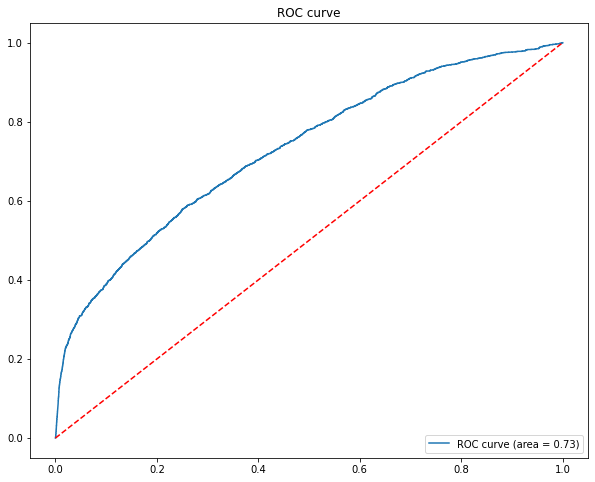

In [66]:
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score

def plot_roc(y_test, y_predict):
    fpr, tpr, _ = roc_curve(y_test, y_predict)
    roc_auc = auc(fpr,tpr)
    print(roc_auc)
    plt.figure(figsize=(10,8))
    plt.title("ROC curve")
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0,1], [0,1],'r--')
    plt.legend(loc="lower right")
plot_roc(y_test, logit_scores)

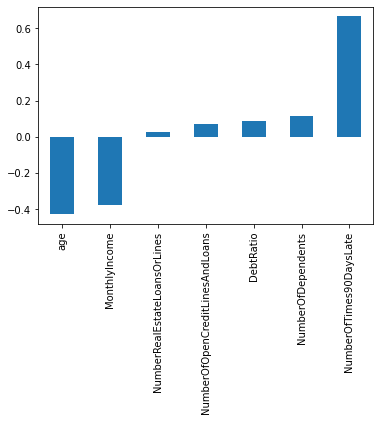

In [67]:
pd.Series(l_model.coef_[0], index=X_test.columns).sort_values().plot(kind='bar');

**Build ML Models**

In [104]:
#Resample
ros = RandomOverSampler(random_state=42,)

X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

#Random Forest
rf = RandomForestClassifier()
rf.fit(X_resampled, y_resampled)

y_pred = rf.predict(X_test_scaled)

print(rf.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.906051699953243
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     27976
           1       0.25      0.21      0.23      1966

    accuracy                           0.91     29942
   macro avg       0.60      0.58      0.59     29942
weighted avg       0.90      0.91      0.90     29942



In [215]:
rf_proba = rf.predict_proba(X_test_scaled)
rf_scores = rf_proba[:,1]

0.719980336291738


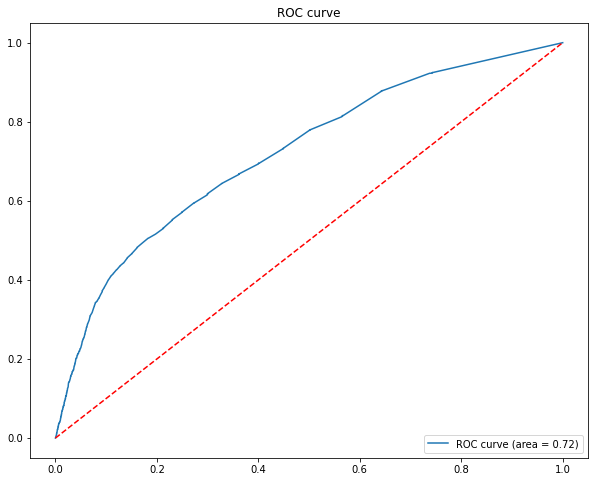

In [216]:
plot_roc(y_test, rf_scores)

- overfitting?
- imbalanced

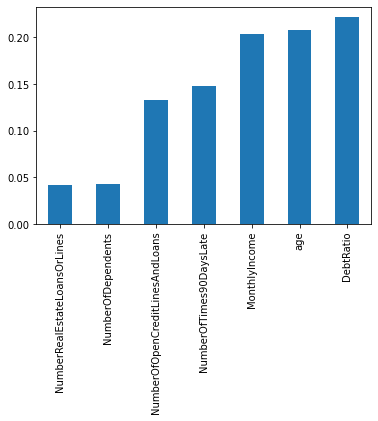

In [105]:
pd.Series(rf.feature_importances_, index=X_test.columns).sort_values().plot(kind='bar');

XgBoost model

In [125]:
import xgboost as xgb
from xgboost import XGBClassifier

In [231]:
xg = XGBClassifier(n_estimators=25, learning_rate=0.1)
xg.fit(X_resampled, y_resampled)

y_pred = xg.predict(X_test_scaled)

print(xg.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred))

0.8273996393026518
              precision    recall  f1-score   support

           0       0.96      0.85      0.90     27976
           1       0.20      0.52      0.29      1966

    accuracy                           0.83     29942
   macro avg       0.58      0.69      0.59     29942
weighted avg       0.91      0.83      0.86     29942



In [217]:
xg_proba = xg.predict_proba(X_test_scaled)
xg_scores = xg_proba[:,1]

0.763858339847176


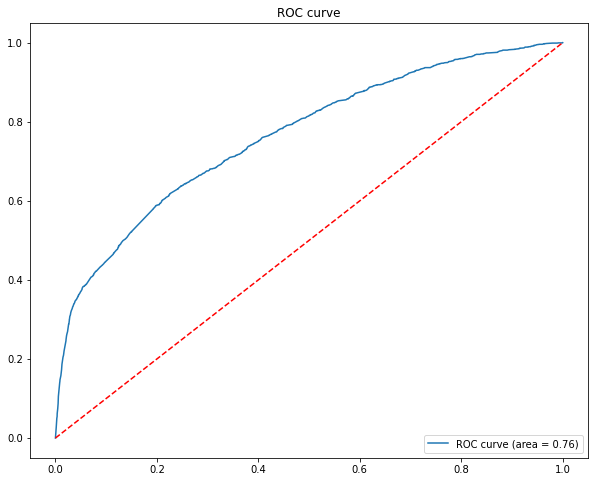

In [218]:
plot_roc(y_test, xg_scores)

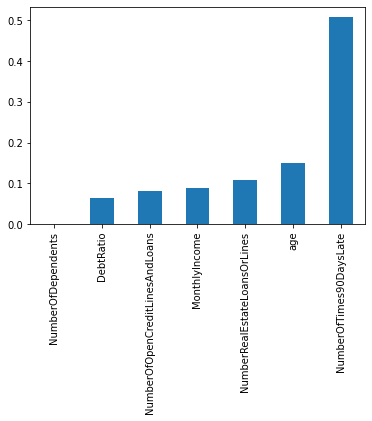

In [208]:
pd.Series(xg.feature_importances_, index=X_test.columns).sort_values().plot(kind='bar');

recall is better than rf

In [197]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1    = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                               min_samples_split=500,
                                                               min_samples_leaf=50,
                                                               max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
                                                               param_grid = param_test1, scoring='roc_auc',
                                                               n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_resampled,y_resampled)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=8, max_features='sqrt',
                                     min_child_weight=1, min_samples_leaf=50,
                                     min_samples_split=500, missing=None,
                                     n_estimators=100, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=10, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'n_estimators': rang

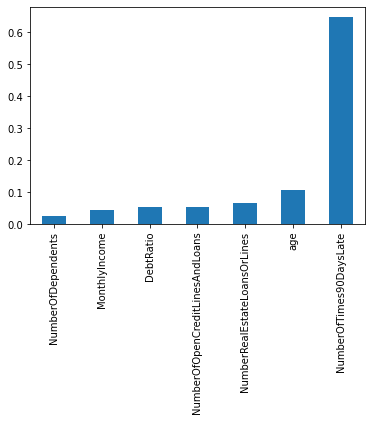

In [129]:
pd.Series(xg.feature_importances_, index=X_test.columns).sort_values().plot(kind='bar');

Neural Networks

In [209]:
n_inputs = X_train.shape[1]

model = Sequential()
model.add(layers.Dense(16, activation ='relu', input_shape =(n_inputs, )))
model.add(layers.Dense(32,activation = 'relu'))
model.add(layers.Dense(32,activation = 'relu'))
model.add(layers.Dense(32,activation = 'relu'))
model.add(layers.Dense(1,activation ='sigmoid'))

In [210]:
model.compile(optimizer = 'rmsprop',
             loss= 'binary_crossentropy',
             metrics = ['accuracy'])

In [211]:
history = model.fit(X_resampled,
                   y_resampled,
                   epochs=30,
                   validation_data=(X_test_scaled, y_test))

Epoch 1/30
6984/6984 [==============================] - 12s 2ms/step - loss: 0.5619 - accuracy: 0.6984 - val_loss: 0.5090 - val_accuracy: 0.7897
Epoch 2/30
6984/6984 [==============================] - 11s 2ms/step - loss: 0.5509 - accuracy: 0.7087 - val_loss: 0.4607 - val_accuracy: 0.8416
Epoch 3/30
6984/6984 [==============================] - 11s 2ms/step - loss: 0.5494 - accuracy: 0.7109 - val_loss: 0.5614 - val_accuracy: 0.7383
Epoch 4/30
6984/6984 [==============================] - 11s 2ms/step - loss: 0.5483 - accuracy: 0.7124 - val_loss: 0.5525 - val_accuracy: 0.7451
Epoch 5/30
6984/6984 [==============================] - 11s 2ms/step - loss: 0.5474 - accuracy: 0.7138 - val_loss: 0.5367 - val_accuracy: 0.7377
Epoch 6/30
6984/6984 [==============================] - 12s 2ms/step - loss: 0.5472 - accuracy: 0.7140 - val_loss: 0.5133 - val_accuracy: 0.7649
Epoch 7/30
6984/6984 [==============================] - 11s 2ms/step - loss: 0.5475 - accuracy: 0.7148 - val_loss: 0.5883 - val_ac

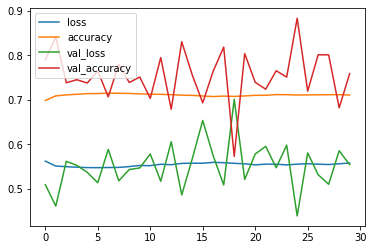

In [212]:
pd.DataFrame(history.history).plot()

In [161]:
y_pred = model.predict(X_test_scaled)

In [162]:
model.evaluate(X_test_scaled, y_test)

936/936 [==============================] - 1s 1ms/step - loss: 0.5647 - accuracy: 0.7495


[0.5646721124649048, 0.7494823336601257]

In [164]:
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_scaled, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [165]:
yhat_classes = yhat_classes[:, 0]

In [167]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)


Accuracy: 0.749482
Precision: 0.155398
Recall: 0.634791
F1 score: 0.249675


In [221]:
model_proba = model.predict_proba(X_test_scaled)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


0.7728009708074148


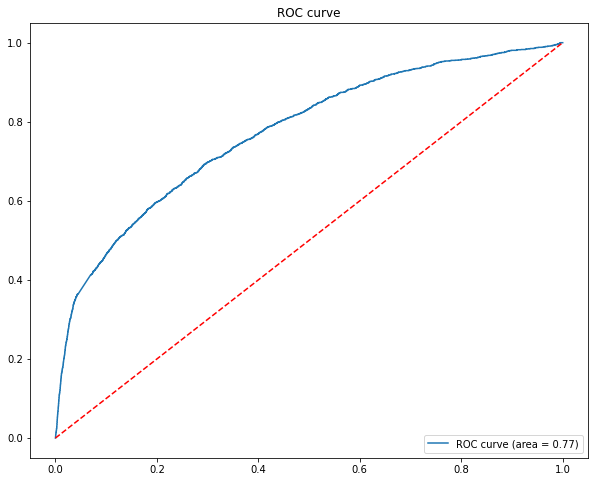

In [223]:
plot_roc(y_test, model_proba)

In [224]:
lr_pred = lr.predict(X_test_scaled)
rf_pred = rf.predict(X_test_scaled)
xg_pred = xg.predict(X_test_scaled)
deepl_pred = model.predict(X_test_scaled)

In [225]:
lr_fpr, lr_tpr, lr_threshold = roc_curve(y_test, lr_pred)
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test, rf_pred)
xg_fpr, xg_tpr, xg_threshold = roc_curve(y_test, xg_pred)
deepl_fpr, deepl_tpr, deepl_threshold = roc_curve(y_test, deepl_pred)

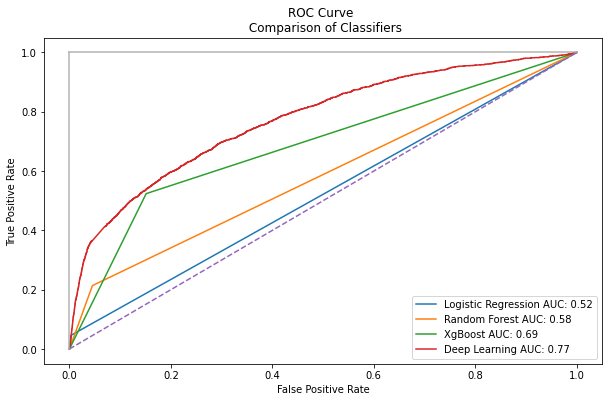

In [226]:
# Plot ROC curves
fig = plt.figure(figsize=(10,6))
plt.title('ROC Curve \n Comparison of Classifiers')
plt.plot(lr_fpr, lr_tpr, label ='Logistic Regression AUC: {:.2f}'.format(roc_auc_score(y_test, lr_pred)))
plt.plot(rf_fpr, rf_tpr, label ='Random Forest AUC: {:.2f}'.format(roc_auc_score(y_test, rf_pred)))
plt.plot(xg_fpr, xg_tpr, label ='XgBoost AUC: {:.2f}'.format(roc_auc_score(y_test, xg_pred)))
plt.plot(deepl_fpr, deepl_tpr, label ='Deep Learning AUC: {:.2f}'.format(roc_auc_score(y_test, deepl_pred)))

plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()


Attempting Deep Learning - Auto encoder model

In [169]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU

# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

In [170]:
from keras.models import Model
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

In [171]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])

In [ ]:
# plot the autoencoder
history = model.fit(X_resampled,\
                    y_resampled,\
                    epochs=150,\
                    batch_size=512,\
                    verbose=2,\
                    validation_data=(X_test_scaled, y_test))

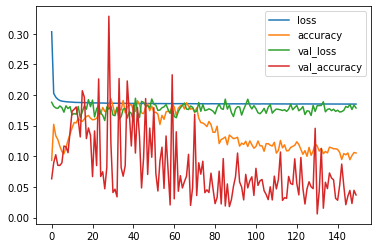

In [173]:
pd.DataFrame(history.history[]).plot()

In [174]:
y_pred = model.predict(X_test_scaled)
model.evaluate(X_test_scaled, y_test)

936/936 [==============================] - 1s 1ms/step - loss: 0.1788 - accuracy: 0.0370


[0.1787879914045334, 0.037004876881837845]

In [180]:
yhat_classes = np.argmax(y_pred,axis=1)